In [1]:
!pip install shap --quiet
!pip install xgboost --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import KNNImputer,IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix , accuracy_score , precision_score , recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from model_utils import *
from scipy.stats import chi2
import shap
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings("ignore")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
data = pd.read_excel("Data for Case Study.xlsx")
data.columns = data.columns.str.replace('"', '').str.replace(" - ", "_").str.replace(" ", "_").str.replace('__', '_').str.replace('_MYSITE', 'MYSITE').str.lower()
df = data.copy()

# Function to handle mixed date formats
def convert_mixed_dates(date):
    if isinstance(date, (int, float)):  # If it's a number, convert from Excel serial date
        return pd.to_datetime('1899-12-30') + pd.to_timedelta(date, unit='D')
    else:  # If it's already a timestamp, convert to datetime
        return pd.to_datetime(date, errors='coerce')

# Apply the function to the column
df['date_replied'] = df['date_replied'].apply(convert_mixed_dates)
print(df.shape)
df.head()

(8460, 66)


,control_count,date_replied,status,unique_identifier,likely_to_recommend_online_site_my_site,purchased_from_site_a,purchased_from_site_b,purchased_from_site_c,purchased_from_site_d,purchased_from_site_e,purchased_from_site_f,purchased_from_site_g,purchased_from_site_h,purchased_from_site_i,purchased_from_site_j,purchased_from_site_k,purchased_from_site_l,purchased_from_site_m,purchased_from_site_n,purchased_from_site_o,purchased_from_site_p,purchased_from_site_q,purchased_from_site_r,purchased_from_site_s,purchased_from_site_t,purchased_from_site_u,purchased_from_site_v,purchased_from_site_w,purchased_from_site_x,purchased_from_site_y,purchased_from_my_site_only,#_of_online_sites_used,mysite_rank,sales_reps_responsiveness,sales_reps_ease_of_making_contact,sales_reps_general_attitude,sales_reps_quotation,sales_reps_relationship,sales_reps_overall_satisfaction,customer_service_responsiveness,customer_service_ease_of_making_contact,customer_service_general_attitude,customer_service_knowledge_of_business,customer_service_issue_resolution,customer_service_keeping_customers_informed,customer_service_overall_satisfaction,delivery_on_time_schedules,delivery_on_time_coverage,delivery_on_time_keeping_customers_informed,delivery_on_time_accuracy_transit_time,delivery_on_time_availability_of_products,delivery_on_time_speed,delivery_on_time_overall_satisfaction,ease_of_business_booking,ease_of_business_documentation,ease_of_business_invoicing,ease_of_business_online_system,ease_of_business_overall_satisfaction,improving_business_opps_knowledge_of_business,improving_business_opps_understanding_of_needs,improving_business_opps_demonstrating_opps,improving_business_opps_specific_offers,improving_business_opps_overall_satisfaction,overall_satisfaction_taking_everything_into_account,proportion_of_purchase_made_with_my_site,future_proportion_of_purchase_made_at_my_site
0,Day 1,2016-08-19,COMPLETED,711315000105288,10,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2.0,8.0,8.0,10.0,10.0,10.0,10.0,10.0,9.0,5.0,5.0,4.0,99.0,9.0,9.0,10.0,8.0,10.0,10.0,10.0,10.0,5.0,2.0,2.0,8.0,8.0,8.0,7.0,8.0,7.0,6.0,8.0,76% to 99%,Increase
1,Day 1,2016-08-19,COMPLETED,391315000163276,7,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2.0,9.0,9.0,8.0,8.0,9.0,9.0,9.0,9.0,9.0,9.0,10.0,9.0,8.0,8.0,8.0,9.0,8.0,9.0,8.0,8.0,8.0,9.0,8.0,8.0,8.0,8.0,10.0,9.0,7.0,8.0,9.0,26% to 50%,Increase
2,Day 1,2016-08-19,COMPLETED,501315000258371,6,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,16.0,7.0,99.0,99.0,99.0,99.0,99.0,99.0,1.0,8.0,7.0,7.0,5.0,1.0,6.0,7.0,8.0,1.0,8.0,8.0,6.0,6.0,7.0,4.0,1.0,8.0,6.0,99.0,99.0,99.0,99.0,99.0,6.0,Don’t know,Don’t know
3,Day 1,2016-08-19,COMPLETED,1001315000329142,7,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,13.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6% to 15%,Stay the same
4,Day 1,2016-08-19,COMPLETED,101315000387196,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,1.0,10.0,10.0,10.0,10.0,10.0,10.0,4.0,10.0,5.0,4.0,10.0,9.0,6.0,9.0,10.0,9.0,8.0,10.0,9.0,9.0,1.0,7.0,1.0,1.0,2.0,10.0,10.0,10.0,10.0,9.0,9.0,51% to 75%,Increase


In [4]:
## Ratings Columns
sales_reps = df.filter(regex='^sales_reps').columns.tolist()
customer_service = df.filter(regex='^customer_service').columns.tolist()
delivery_on_time = df.filter(regex='^delivery_on_time').columns.tolist()
ease_of_business = df.filter(regex='^ease_of_business').columns.tolist()
improving_business_opps = df.filter(regex='^improving_business_opps').columns.tolist()
product_purchased_col = df.filter(regex='^purchased_from').columns.tolist()

### In a rating based column i.e 0 - 10 rating, a 99 value may indicate a system generated error or missing value coded as 99

In [5]:
rating_columns = sales_reps + customer_service + delivery_on_time + ease_of_business + improving_business_opps + ['overall_satisfaction_taking_everything_into_account']
for i in rating_columns:
    df[i] = np.where(df[i] == 99, np.nan, df[i])

### Boxplot for Outlier

Q1: 5.0 & 5.0
Q3: 10.0 & 9.0
IQR: 5.0 & 4.0


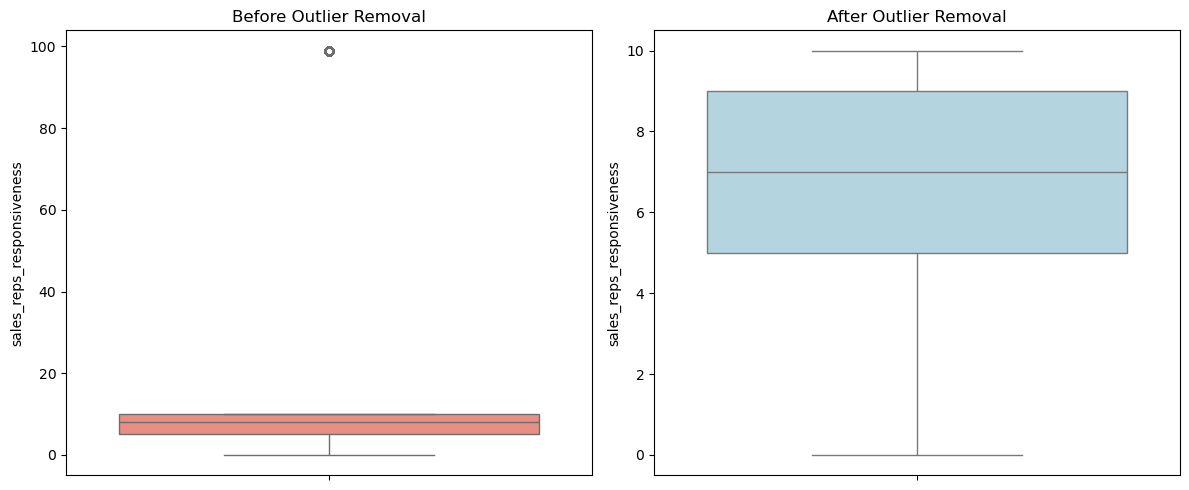

Q1: 5.0 & 5.0
Q3: 10.0 & 9.0
IQR: 5.0 & 4.0


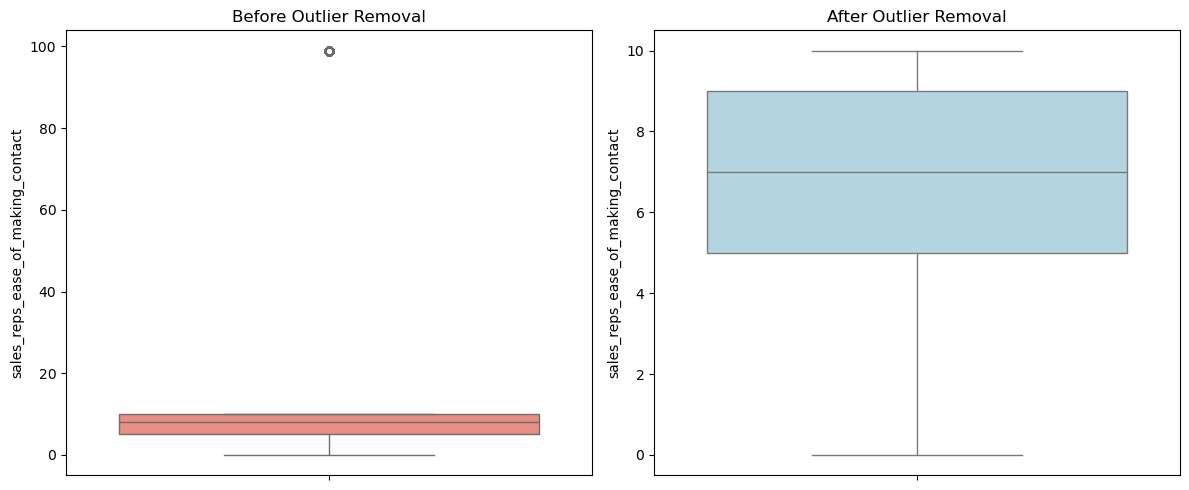

Q1: 6.0 & 5.0
Q3: 10.0 & 9.0
IQR: 4.0 & 4.0


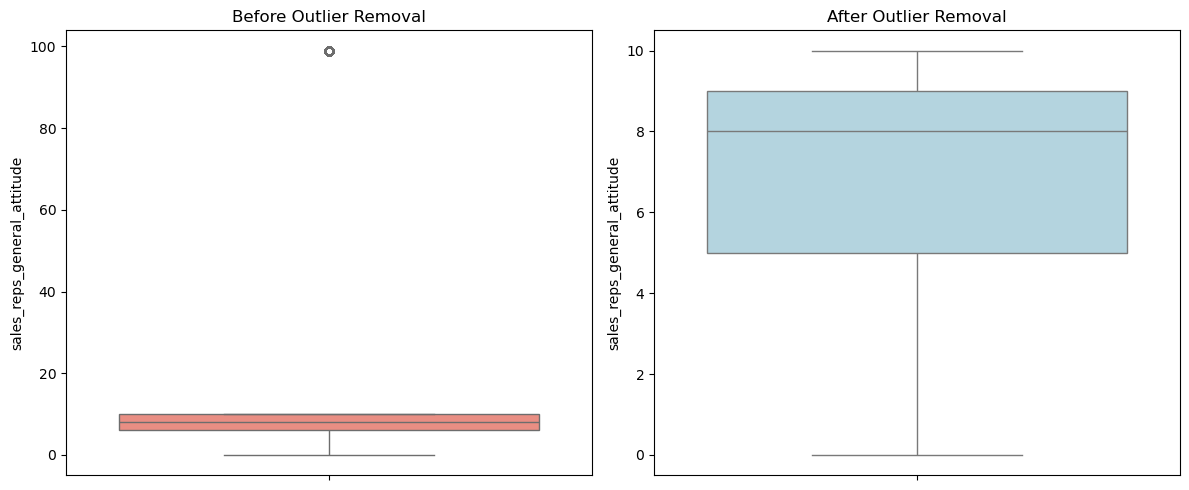

Q1: 5.0 & 5.0
Q3: 10.0 & 9.0
IQR: 5.0 & 4.0


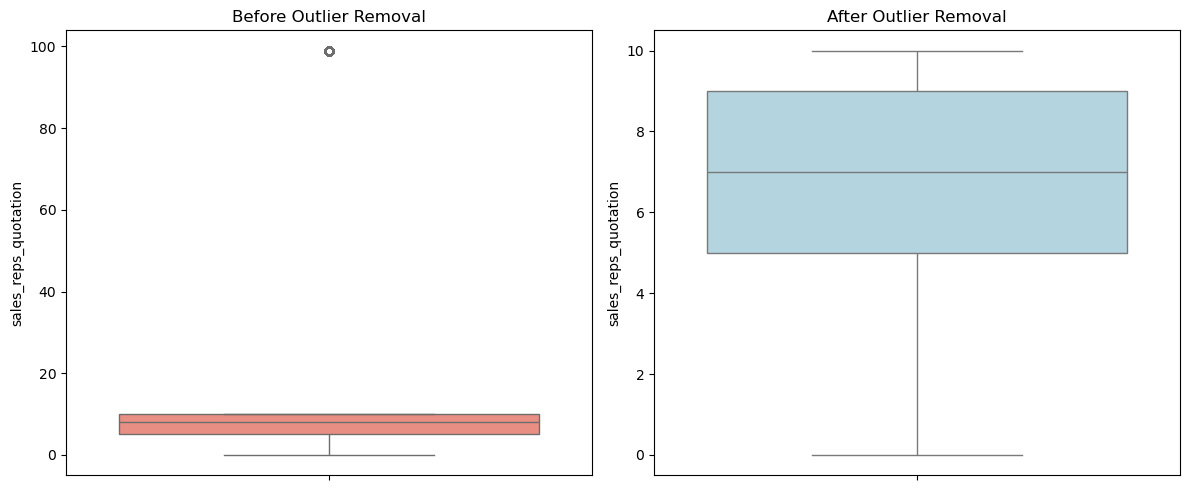

Q1: 6.0 & 5.0
Q3: 10.0 & 9.0
IQR: 4.0 & 4.0


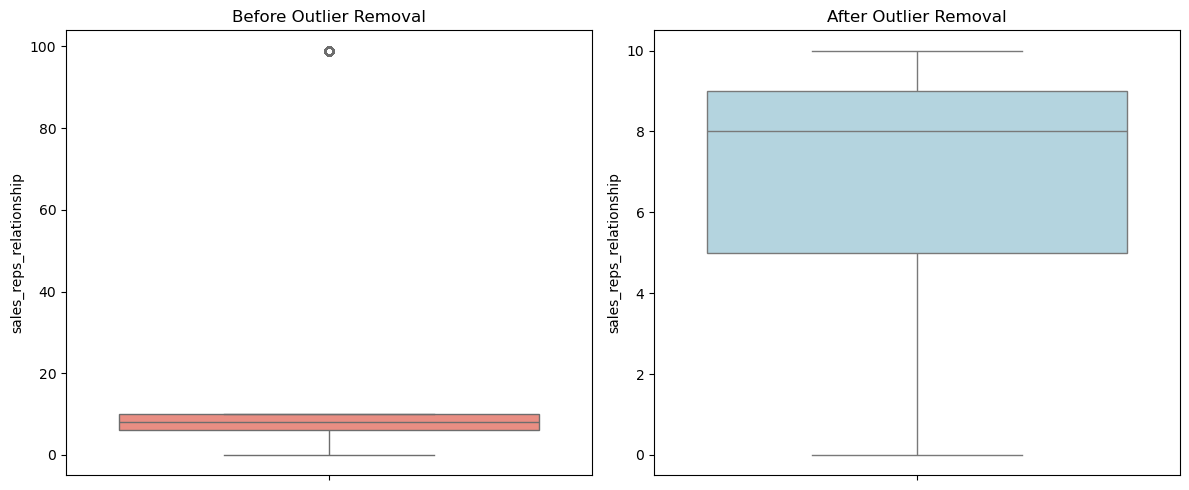

Q1: 5.0 & 5.0
Q3: 10.0 & 9.0
IQR: 5.0 & 4.0


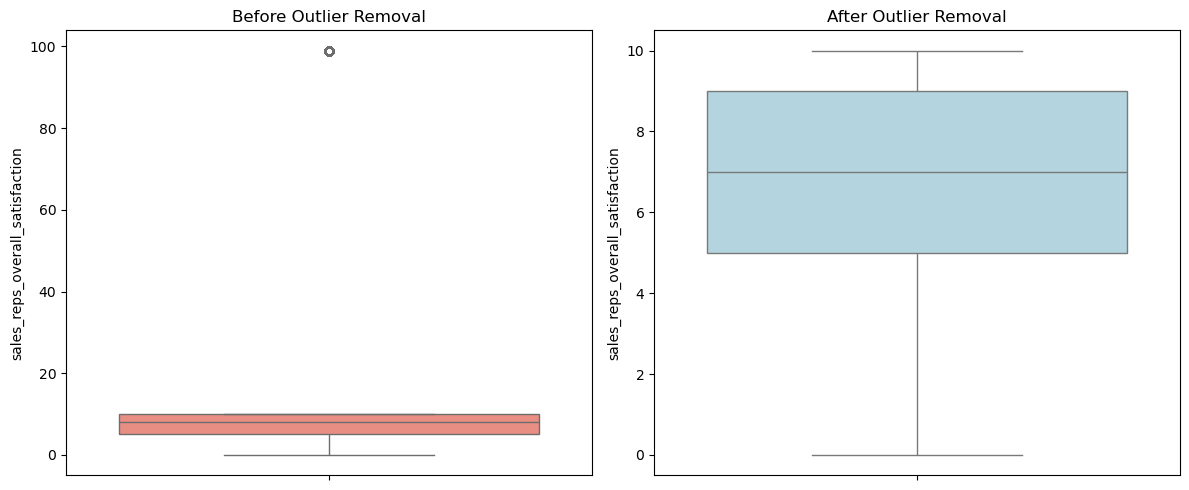

Q1: 5.0 & 5.0
Q3: 9.0 & 9.0
IQR: 4.0 & 4.0


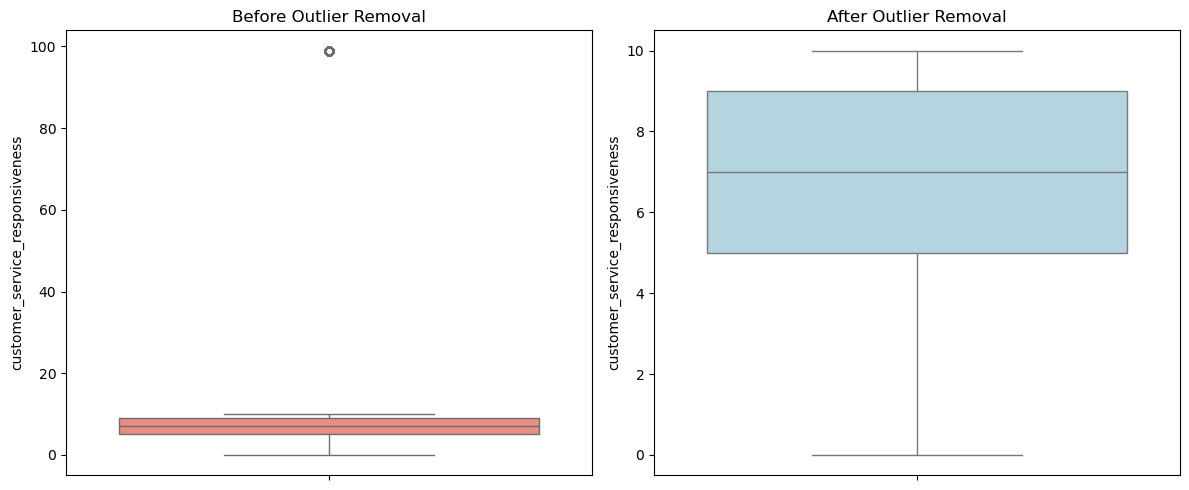

Q1: 4.0 & 4.0
Q3: 9.0 & 9.0
IQR: 5.0 & 5.0


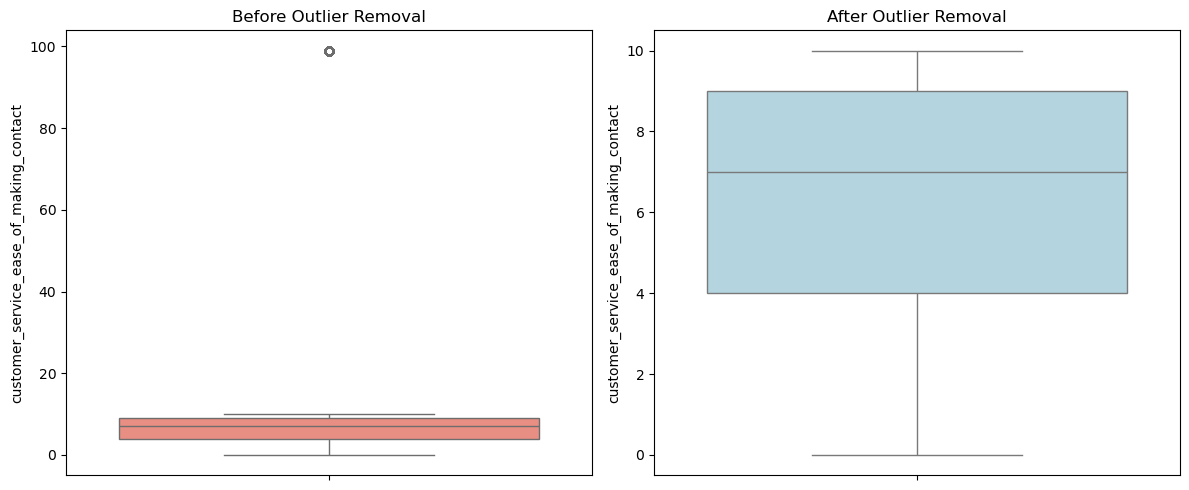

Q1: 5.0 & 5.0
Q3: 9.0 & 9.0
IQR: 4.0 & 4.0


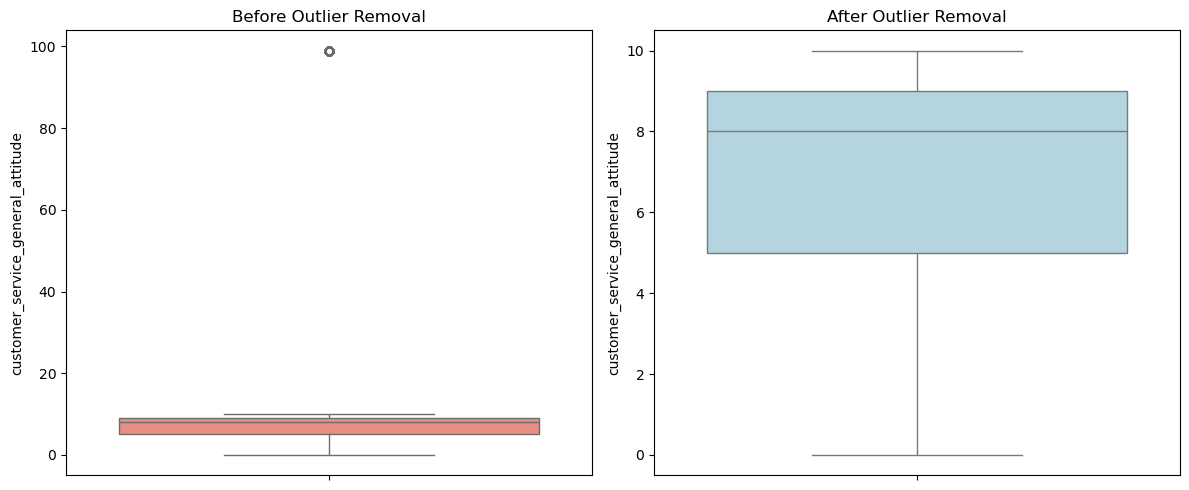

Q1: 5.0 & 5.0
Q3: 9.0 & 9.0
IQR: 4.0 & 4.0


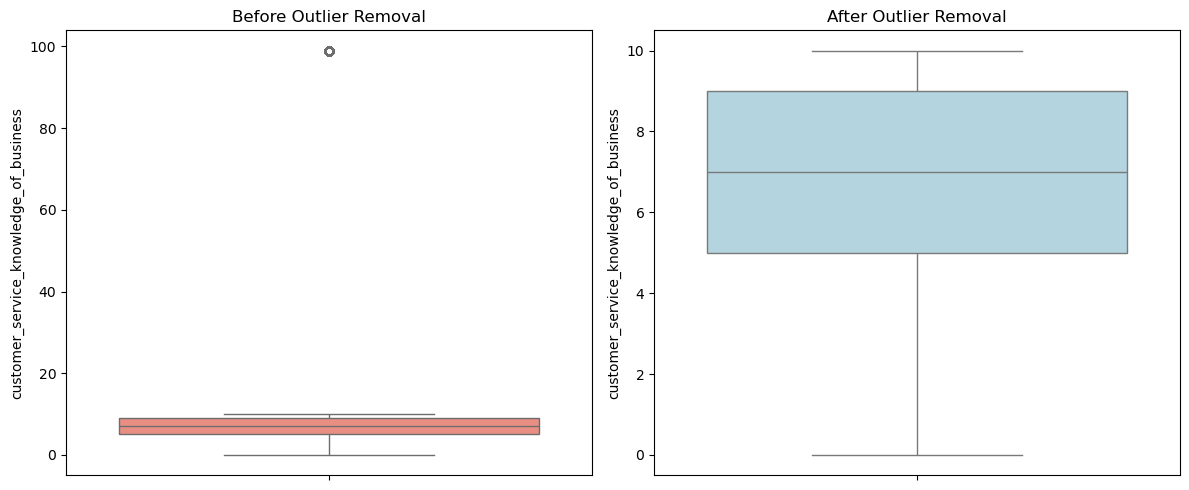

Q1: 4.0 & 4.0
Q3: 9.0 & 9.0
IQR: 5.0 & 5.0


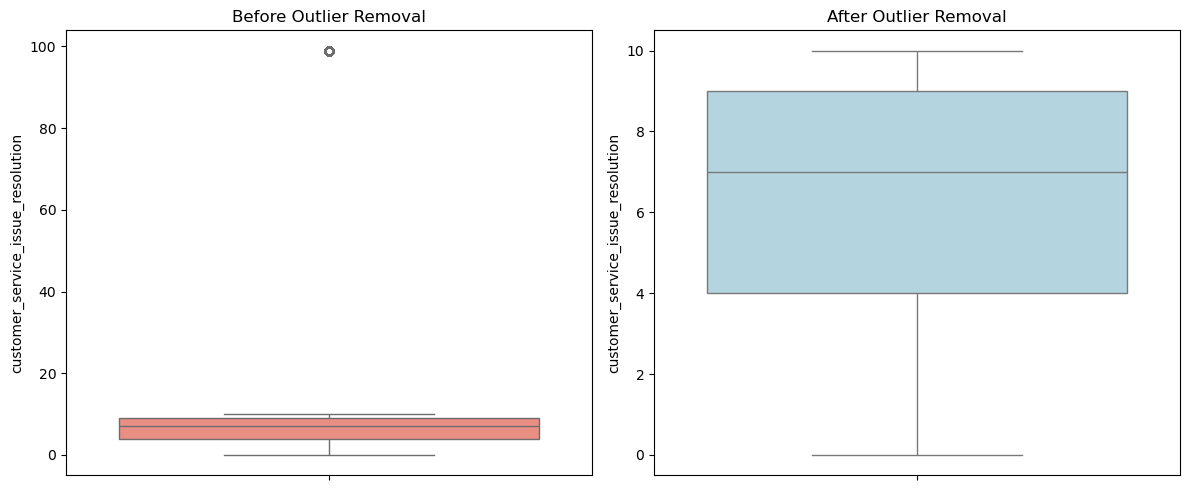

Q1: 4.0 & 4.0
Q3: 9.0 & 9.0
IQR: 5.0 & 5.0


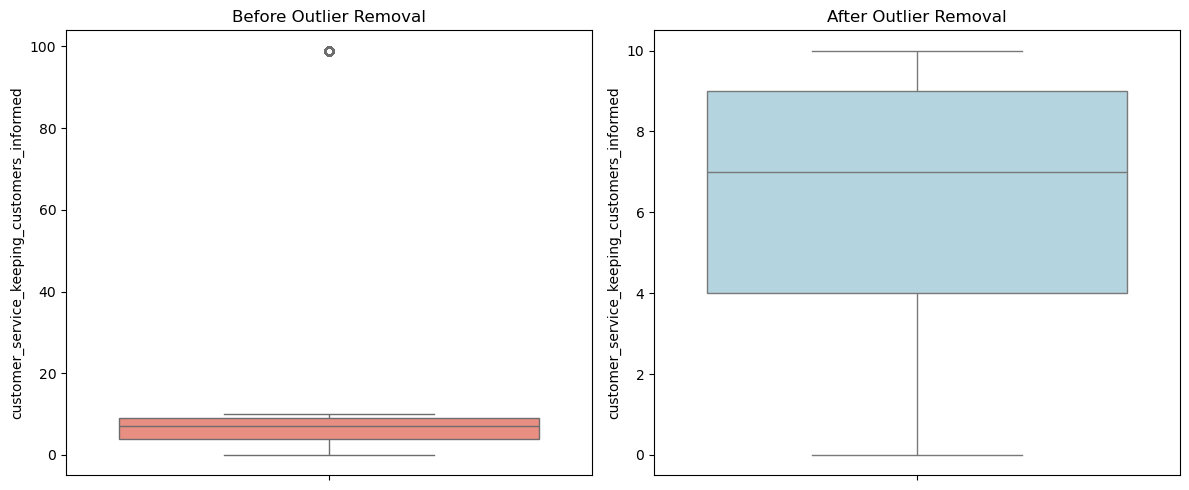

Q1: 5.0 & 5.0
Q3: 9.0 & 9.0
IQR: 4.0 & 4.0


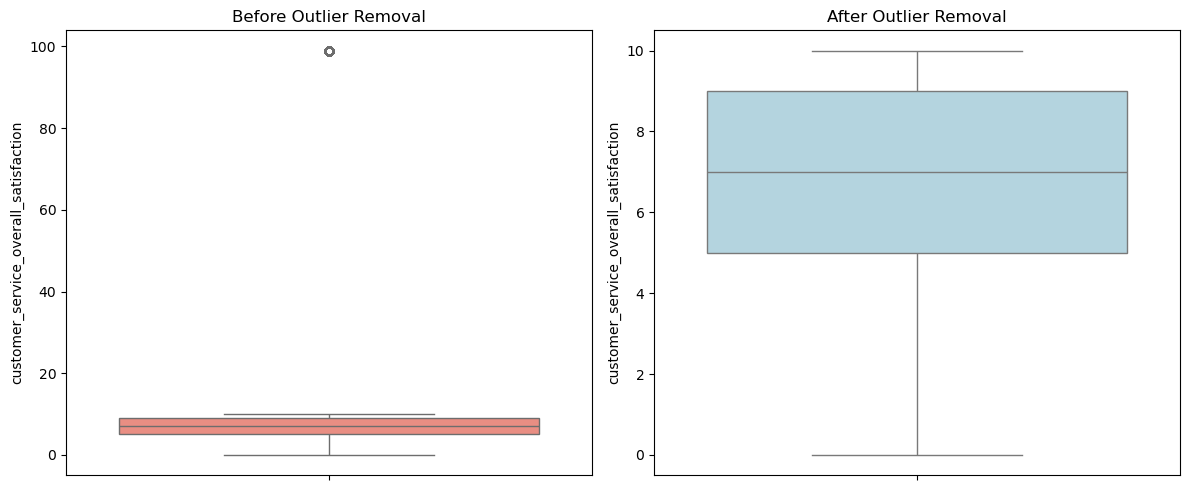

Q1: 6.0 & 6.0
Q3: 9.0 & 9.0
IQR: 3.0 & 3.0


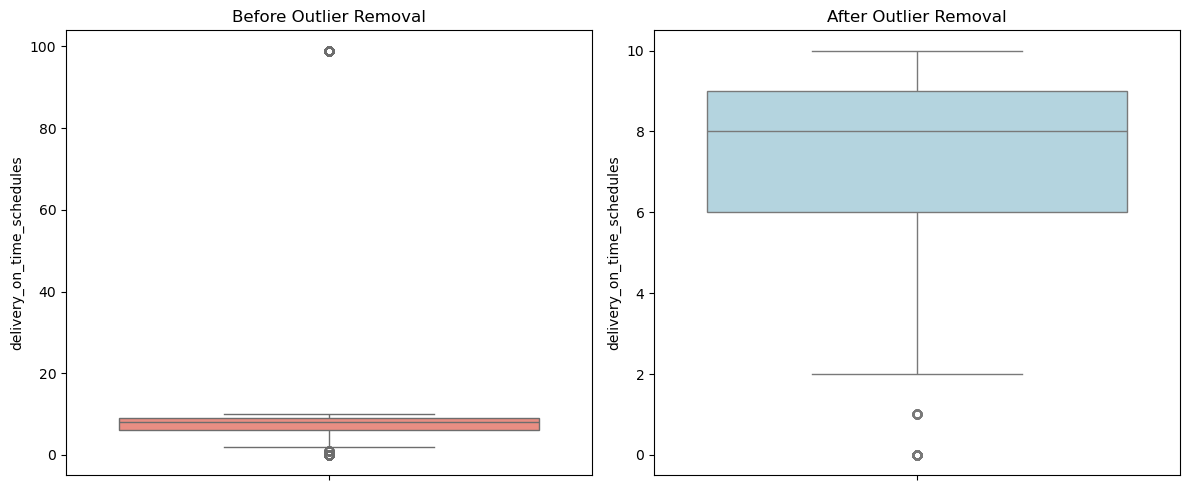

Q1: 7.0 & 7.0
Q3: 10.0 & 9.0
IQR: 3.0 & 2.0


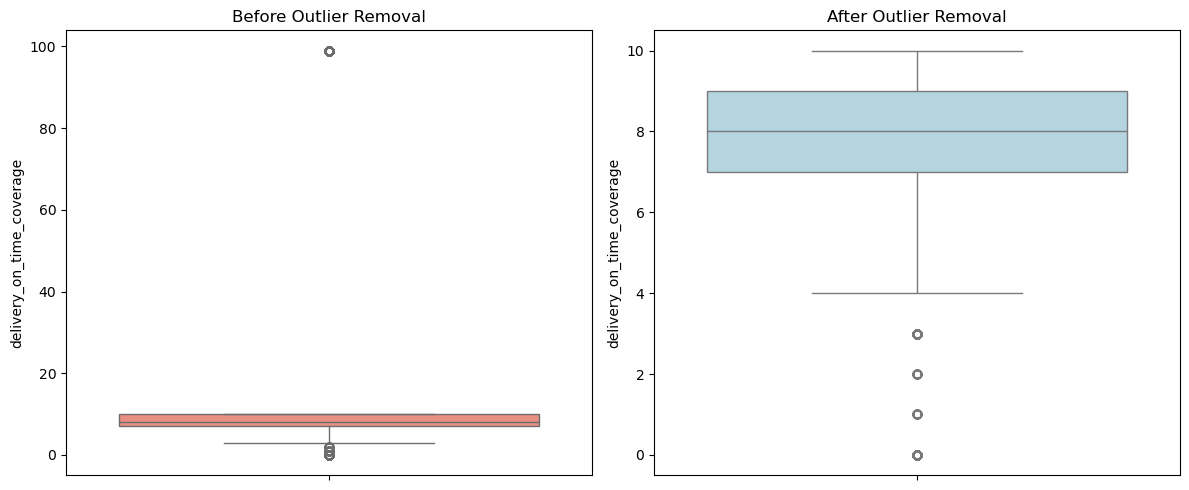

Q1: 5.0 & 5.0
Q3: 9.0 & 9.0
IQR: 4.0 & 4.0


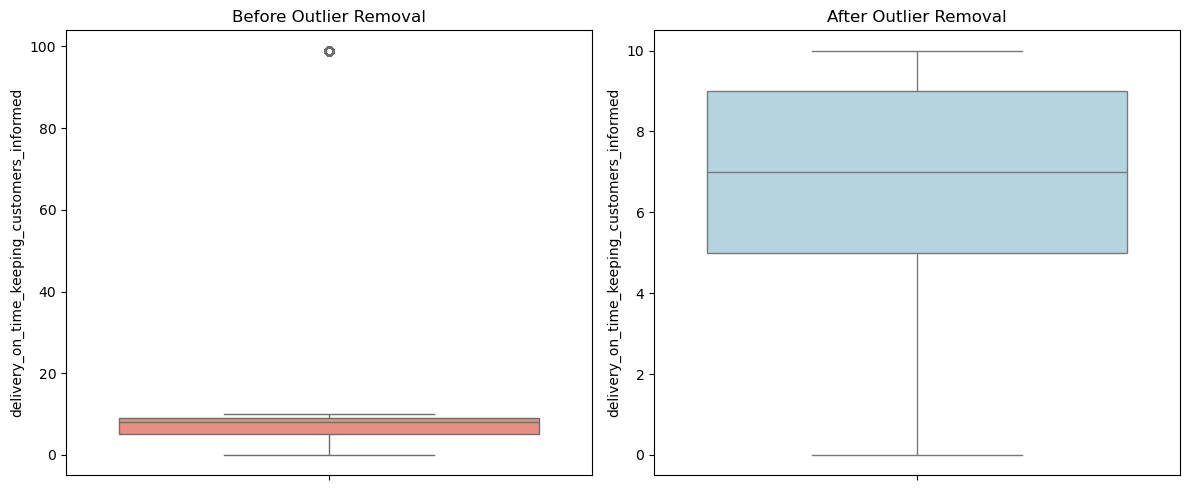

Q1: 6.0 & 6.0
Q3: 9.0 & 9.0
IQR: 3.0 & 3.0


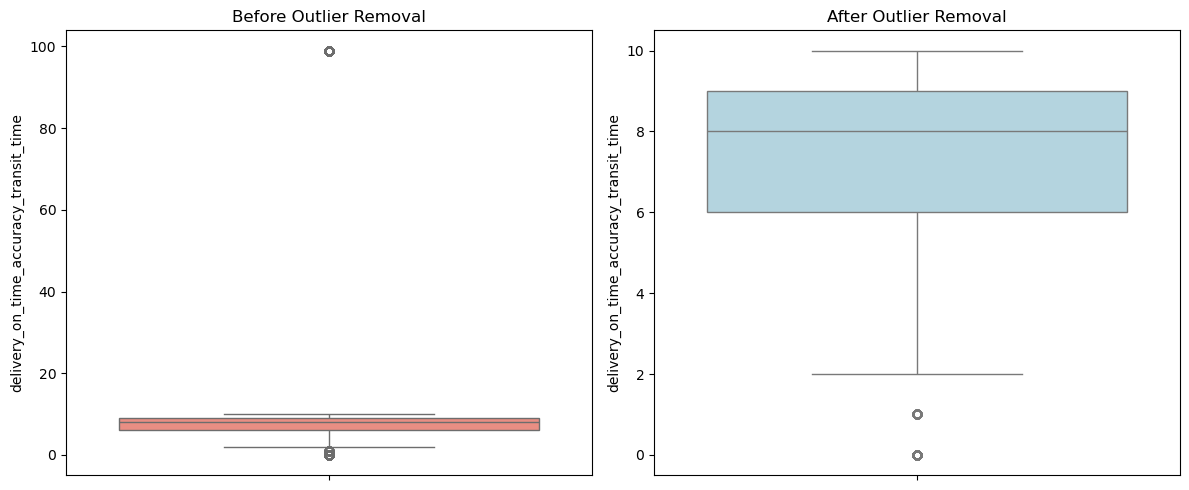

Q1: 6.0 & 6.0
Q3: 9.0 & 9.0
IQR: 3.0 & 3.0


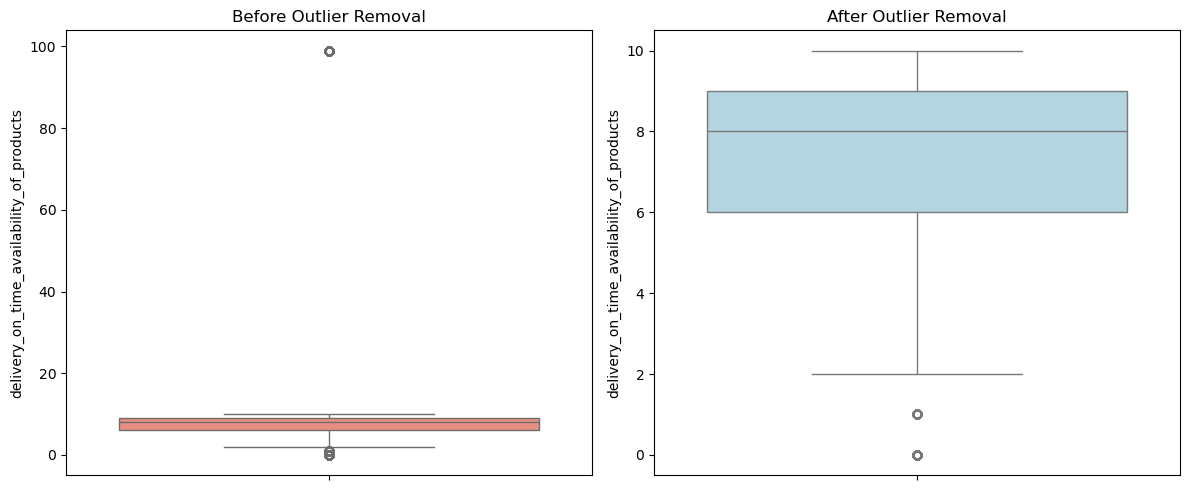

Q1: 6.0 & 6.0
Q3: 9.0 & 9.0
IQR: 3.0 & 3.0


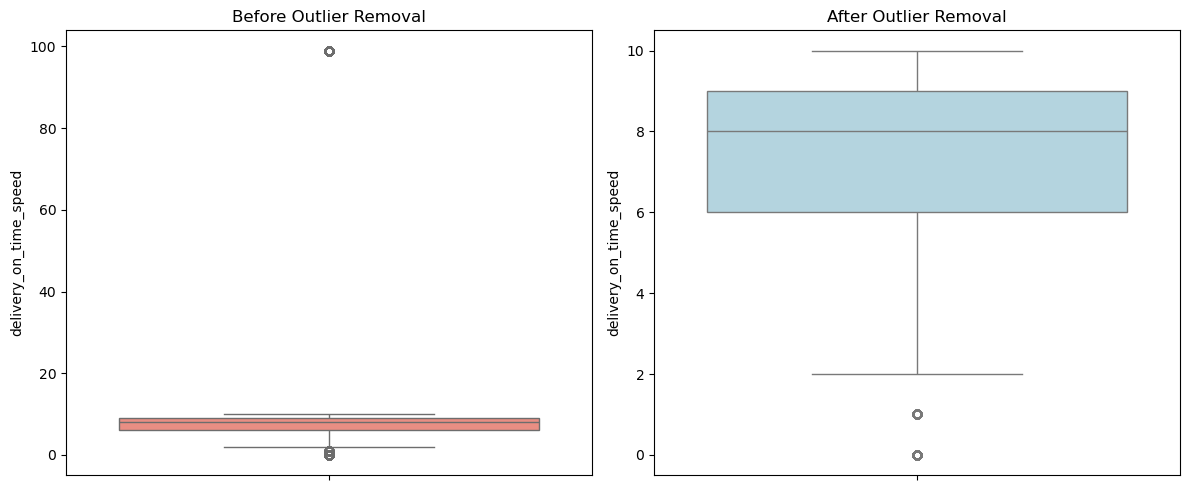

Q1: 6.0 & 6.0
Q3: 9.0 & 9.0
IQR: 3.0 & 3.0


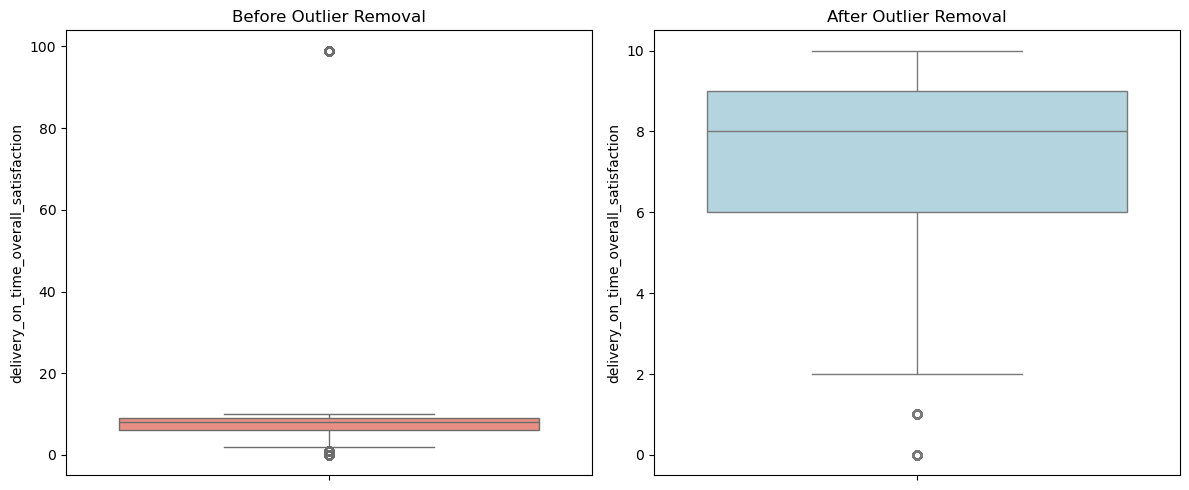

Q1: 6.0 & 6.0
Q3: 10.0 & 9.0
IQR: 4.0 & 3.0


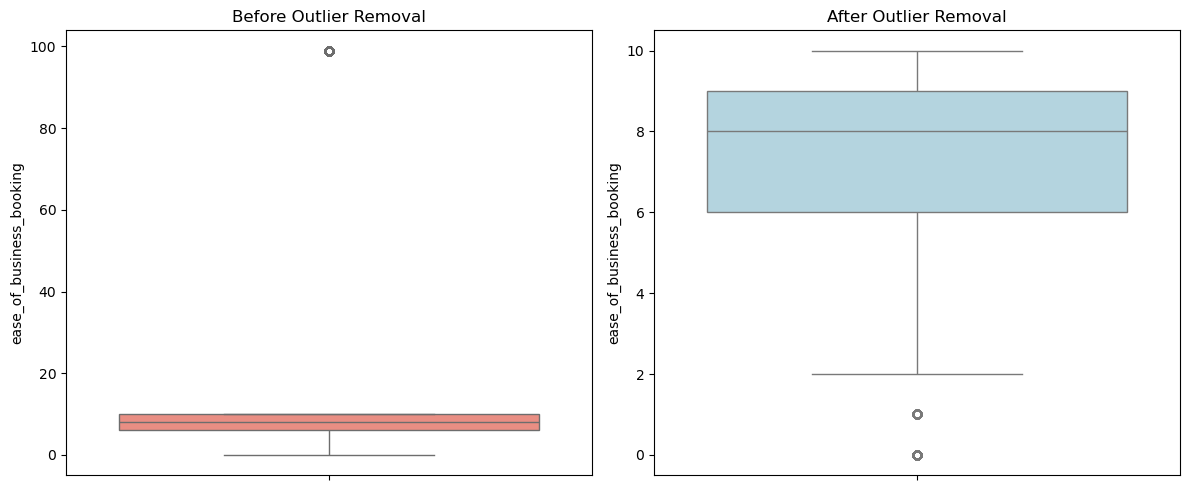

Q1: 5.0 & 5.0
Q3: 9.0 & 9.0
IQR: 4.0 & 4.0


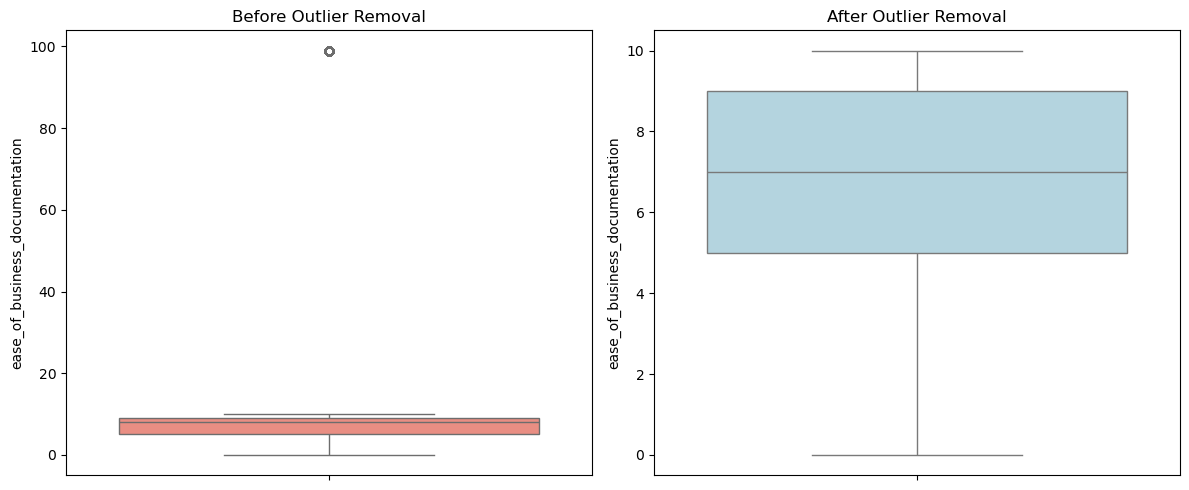

Q1: 5.0 & 4.0
Q3: 9.0 & 9.0
IQR: 4.0 & 5.0


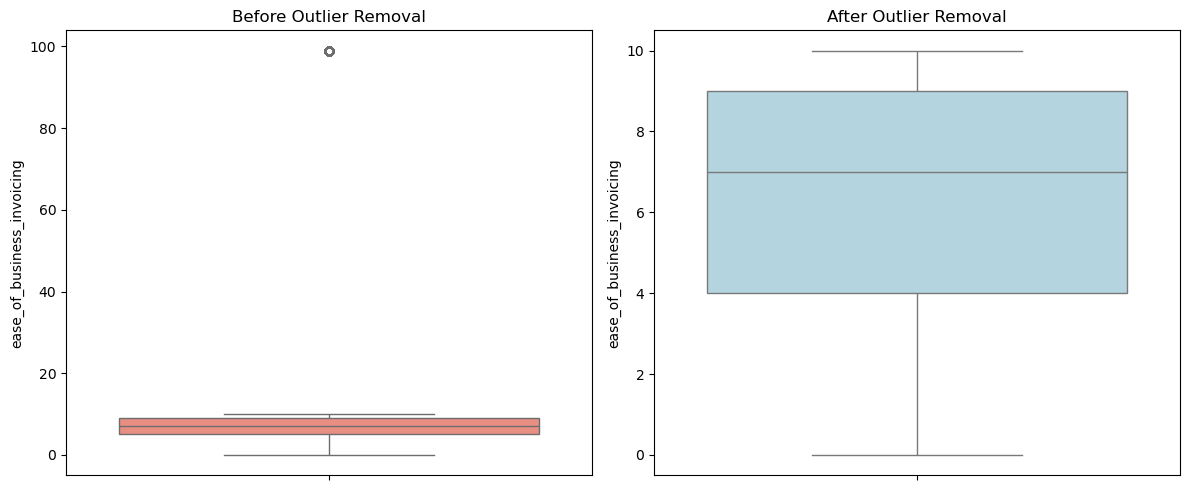

Q1: 6.0 & 5.0
Q3: 9.0 & 9.0
IQR: 3.0 & 4.0


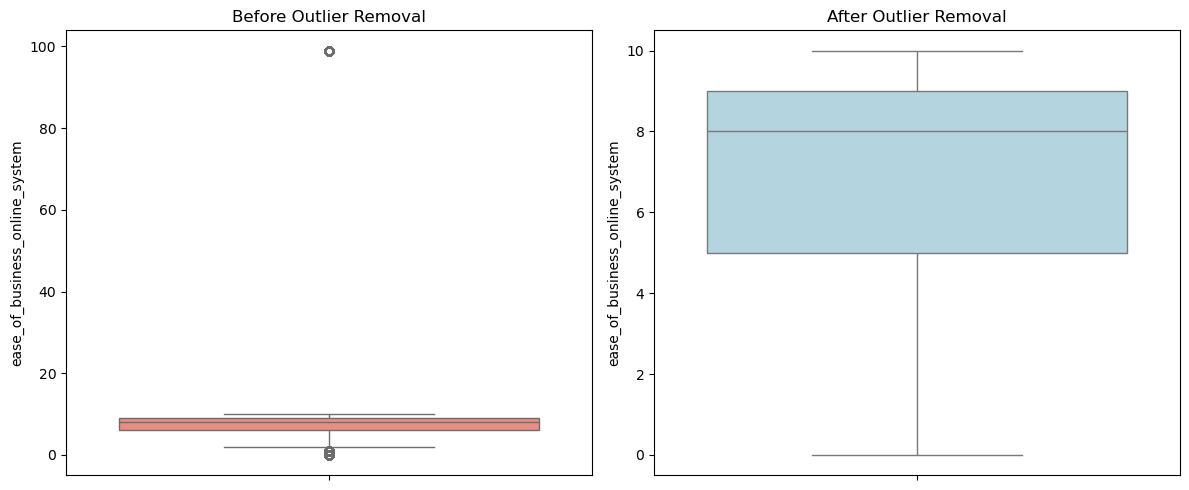

Q1: 5.0 & 5.0
Q3: 9.0 & 9.0
IQR: 4.0 & 4.0


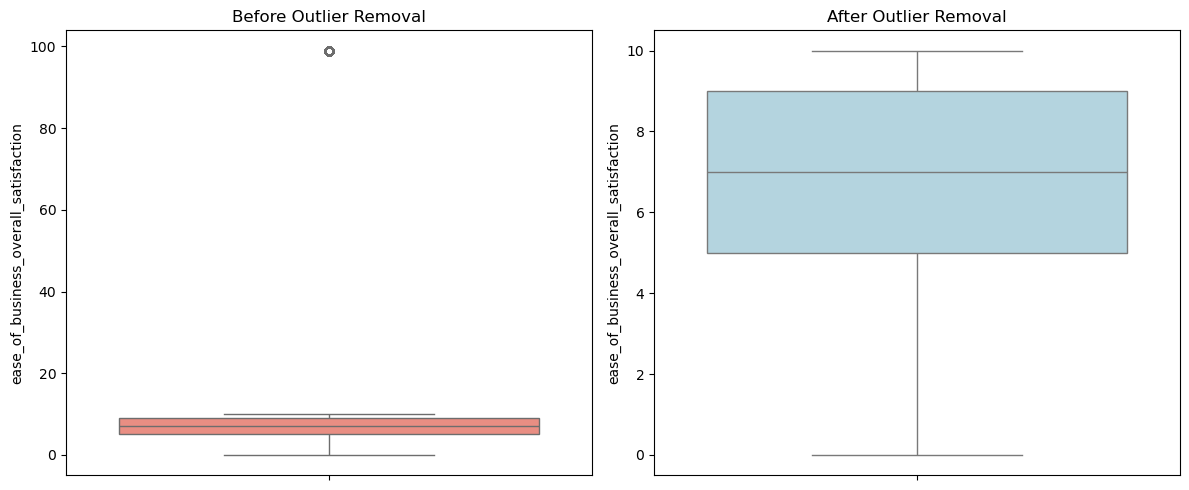

Q1: 6.0 & 5.0
Q3: 10.0 & 9.0
IQR: 4.0 & 4.0


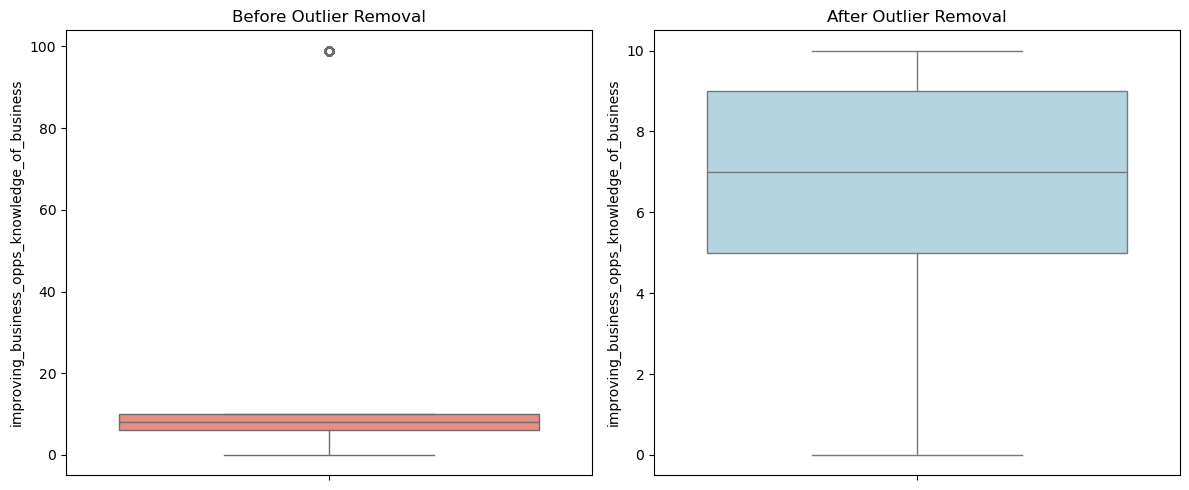

Q1: 5.0 & 5.0
Q3: 10.0 & 9.0
IQR: 5.0 & 4.0


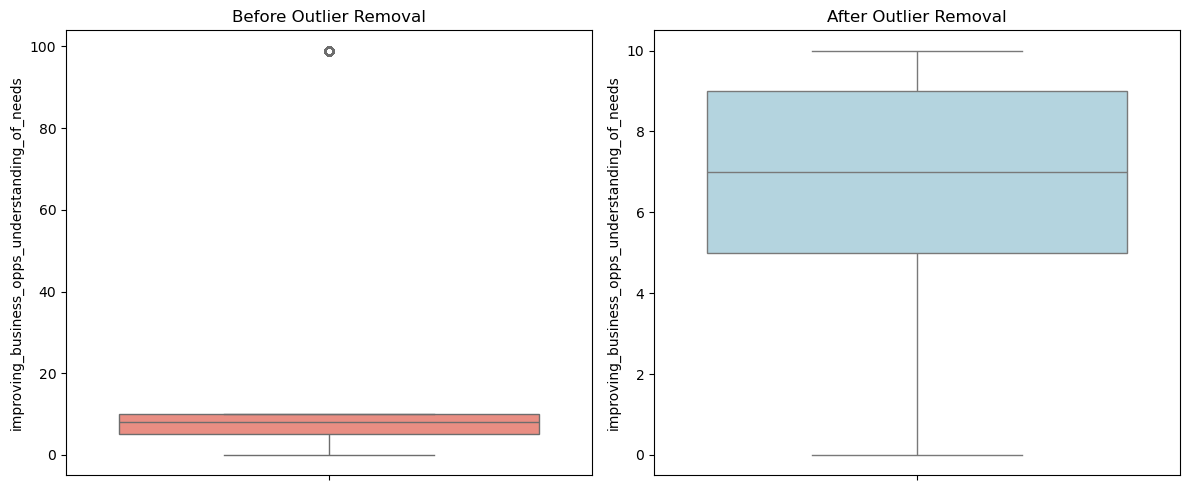

Q1: 5.0 & 5.0
Q3: 10.0 & 9.0
IQR: 5.0 & 4.0


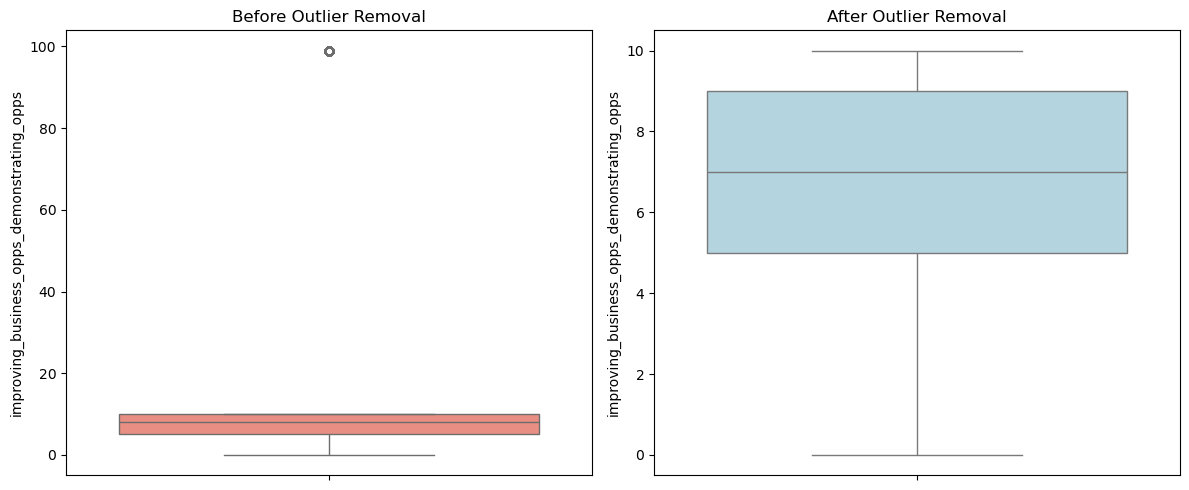

Q1: 5.0 & 5.0
Q3: 10.0 & 9.0
IQR: 5.0 & 4.0


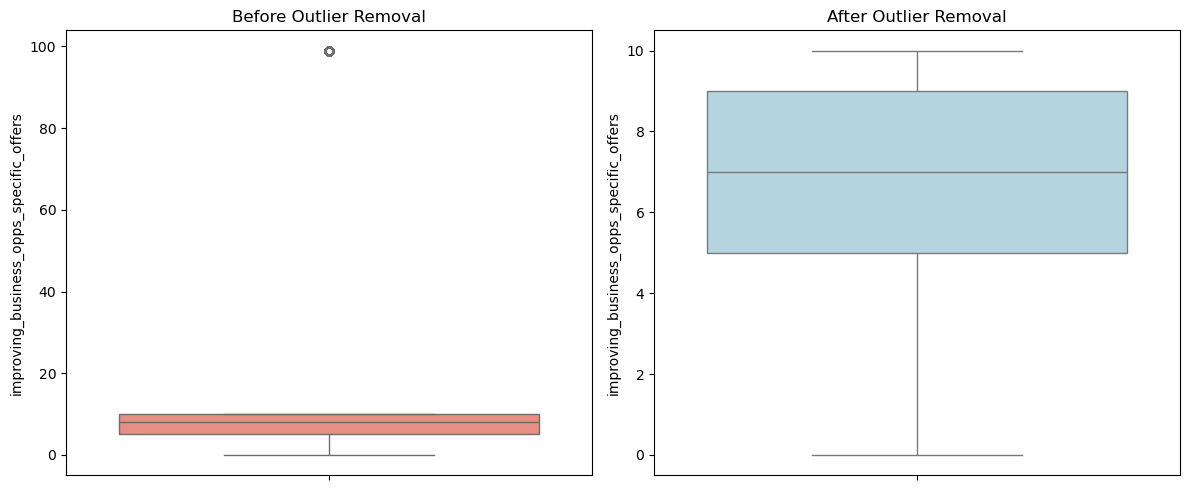

Q1: 5.0 & 5.0
Q3: 10.0 & 9.0
IQR: 5.0 & 4.0


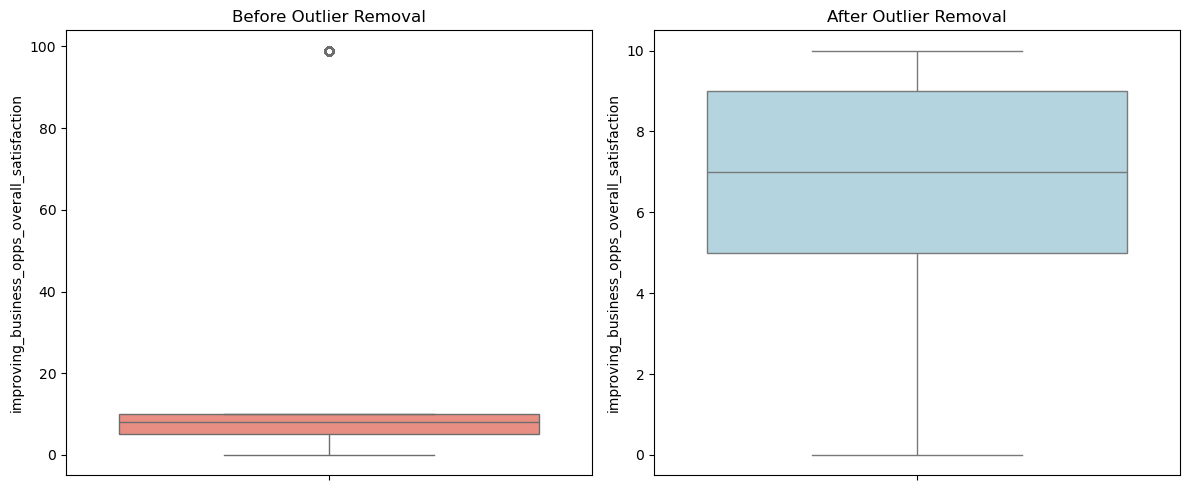

Q1: 5.0 & 5.0
Q3: 9.0 & 9.0
IQR: 4.0 & 4.0


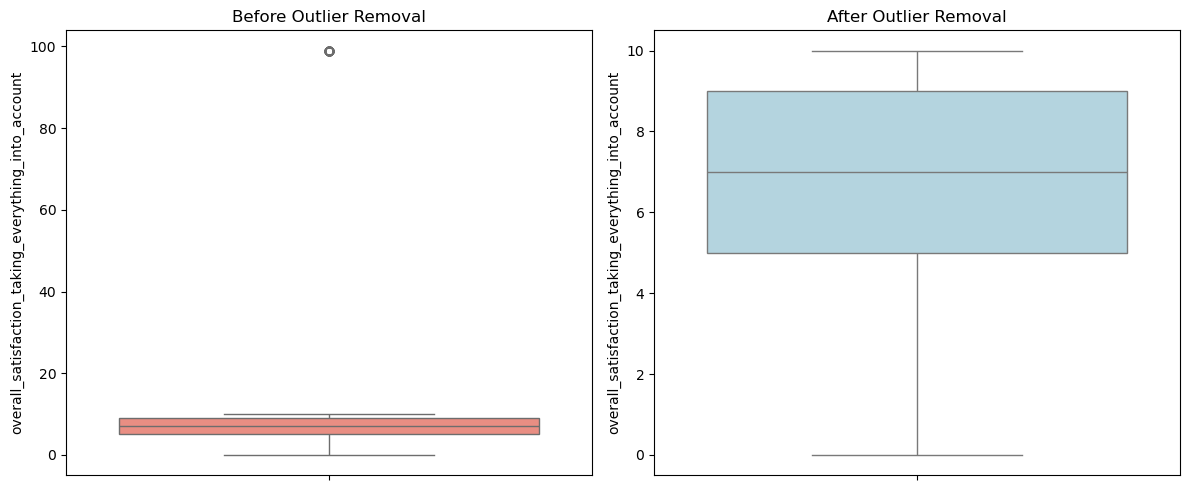

In [6]:
for i in rating_columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    Q1 = data[i].quantile(0.25)
    Q3  = data[i].quantile(0.75)
    IQR = Q3  - Q1
    
    Q1_wo_outlier = df[i].quantile(0.25)
    Q3_wo_outlier  = df[i].quantile(0.75)
    IQR_wo_outlier  = Q3_wo_outlier  - Q1_wo_outlier 
    
    print(f"Q1: {Q1} & {Q1_wo_outlier}")
    print(f"Q3: {Q3} & {Q3_wo_outlier}")
    print(f"IQR: {IQR} & {IQR_wo_outlier}")
    
    
    # Boxplot before removing outliers
    sns.boxplot(y=data[i], ax=axes[0], color="salmon")
    axes[0].set_title("Before Outlier Removal")

    # Boxplot after removing outliers
    sns.boxplot(y=df[i], ax=axes[1], color="lightblue")
    axes[1].set_title("After Outlier Removal")

    # Show plots
    plt.tight_layout()
    plt.show()
    print("============================================================================================================")

### Checking Association of Categorical varibale with Target variable

In [7]:
def categorize_nps(score):
    if score >= 7:
        return 1  # Promoters (9-10) & Passives (7-8)
    else:
        return 0  # Detractors

df["LTR_Category"] = df["likely_to_recommend_online_site_my_site"].apply(categorize_nps)

### Chi square test to check if there is any association between Categorical Variable and Target variable
##### If p_value is less than 0.05, then there is association between topic variable and target variable
##### Higher Chi2 value, higher is the association between two Categorical Variable

In [8]:
from scipy.stats import chi2_contingency
def chisquare(df,target):
    results = []
    for col in df.columns:
        conti_table = pd.crosstab(df[col],target)
        chi2, p, dof, expected = chi2, p, dof, expected = chi2_contingency(conti_table)
        results.append({"Variable":col, "Chi2":chi2, "p-value":round(p,3)})
        
    results_df = pd.DataFrame(results)
    return results_df

In [9]:
chisquare(df[['proportion_of_purchase_made_with_my_site','future_proportion_of_purchase_made_at_my_site']],df['LTR_Category'])

,Variable,Chi2,p-value
0,proportion_of_purchase_made_with_my_site,432.763728,0.0
1,future_proportion_of_purchase_made_at_my_site,1133.023395,0.0


In [10]:
df2 = pd.DataFrame(pd.crosstab(df['proportion_of_purchase_made_with_my_site'],df['LTR_Category'])).rename(columns = {0:'Detractors',1:'Promotors/Passive'}).sort_values(by = 'Promotors/Passive',ascending = False).reset_index()
df_1 = pd.DataFrame(round(pd.crosstab(df['proportion_of_purchase_made_with_my_site'],df['LTR_Category'],normalize = 'index')*100,2)).rename(columns = {0:'Detractors%',1:'Promotors/Passive%'}).sort_values(by = 'Promotors/Passive%', ascending = False).reset_index()
df_1['Lift'] = df_1['Promotors/Passive%']/55
df3 = pd.merge(df2,df_1,how = 'inner',on = 'proportion_of_purchase_made_with_my_site').sort_values(by = 'Lift', ascending = False).reset_index()
display(df3)

LTR_Category,index,proportion_of_purchase_made_with_my_site,Detractors,Promotors/Passive,Detractors%,Promotors/Passive%,Lift
0,5,76% to 99%,73,323,18.43,81.57,1.483091
1,1,51% to 75%,251,578,30.28,69.72,1.267636
2,0,26% to 50%,339,604,35.95,64.05,1.164545
3,2,16% to 25%,365,466,43.92,56.08,1.019636
4,4,Don’t know,274,341,44.55,55.45,1.008182
5,6,Prefer not to say,339,322,51.29,48.71,0.885636
6,3,6% to 15%,447,380,54.05,45.95,0.835455
7,7,1% to 5%,488,208,70.11,29.89,0.543455


In [11]:
conditions = [(df['proportion_of_purchase_made_with_my_site'].isin(['Prefer not to say','Don’t know'])),
                 (df['proportion_of_purchase_made_with_my_site'] == '1% to 5%'),
                 (df['proportion_of_purchase_made_with_my_site'] == '6% to 15%'),
                 (df['proportion_of_purchase_made_with_my_site'] == '16% to 25%'),
                 (df['proportion_of_purchase_made_with_my_site'] == '26% to 50%'),
                 (df['proportion_of_purchase_made_with_my_site'] == '51% to 75%'),
                 (df['proportion_of_purchase_made_with_my_site'] == '76% to 99%'),
                 (df['proportion_of_purchase_made_with_my_site'].isna())]

values = [0,1,2,3,4,5,6,np.nan]
df['proportion_of_purchase_made_with_my_site_numeric'] = np.select(conditions ,values)

### Checking Median Values of Rating Columns w.r.t LTR

In [12]:
df.groupby('likely_to_recommend_online_site_my_site')[rating_columns + ['proportion_of_purchase_made_with_my_site_numeric','mysite_rank']].median()

,sales_reps_responsiveness,sales_reps_ease_of_making_contact,sales_reps_general_attitude,sales_reps_quotation,sales_reps_relationship,sales_reps_overall_satisfaction,customer_service_responsiveness,customer_service_ease_of_making_contact,customer_service_general_attitude,customer_service_knowledge_of_business,customer_service_issue_resolution,customer_service_keeping_customers_informed,customer_service_overall_satisfaction,delivery_on_time_schedules,delivery_on_time_coverage,delivery_on_time_keeping_customers_informed,delivery_on_time_accuracy_transit_time,delivery_on_time_availability_of_products,delivery_on_time_speed,delivery_on_time_overall_satisfaction,ease_of_business_booking,ease_of_business_documentation,ease_of_business_invoicing,ease_of_business_online_system,ease_of_business_overall_satisfaction,improving_business_opps_knowledge_of_business,improving_business_opps_understanding_of_needs,improving_business_opps_demonstrating_opps,improving_business_opps_specific_offers,improving_business_opps_overall_satisfaction,overall_satisfaction_taking_everything_into_account,proportion_of_purchase_made_with_my_site_numeric,mysite_rank
likely_to_recommend_online_site_my_site,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,5.0,2.0,4.0,5.0,3.0,3.0,3.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0
1,2.0,2.0,3.0,2.0,3.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,6.0,7.0,4.0,6.0,6.0,5.0,5.0,5.0,3.0,2.0,5.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,4.0
2,3.0,2.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,3.0,3.0,6.0,7.0,4.0,5.0,6.0,5.0,5.0,5.0,4.0,3.0,5.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,2.0,4.0
3,4.0,4.0,5.0,4.0,5.0,4.0,3.0,4.0,5.0,4.0,3.0,3.0,3.5,6.0,7.0,5.0,6.0,6.0,6.0,5.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,4.5,5.0,4.0,2.0,4.0
4,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,6.0,7.0,5.0,6.0,6.0,6.0,6.0,6.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,4.0
5,6.0,5.0,6.0,5.0,6.0,6.0,5.0,5.0,6.0,5.0,5.0,5.0,5.0,7.0,7.0,6.0,7.0,7.0,6.0,6.5,7.0,6.0,5.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,6.0,2.0,3.0
6,6.0,6.0,7.0,6.0,7.0,7.0,6.0,6.0,7.0,6.0,6.0,6.0,6.0,7.0,8.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,6.0,7.0,7.0,6.0,6.0,6.0,7.0,2.0,3.0
7,7.0,7.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,8.0,7.0,7.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,3.0,2.0
8,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,3.0,2.0


## Information Value and Weight of Evidence dataset Creation.

#### Calculating the IV and WOE

#### Target Variable: LTR_Category
Information Value (IV) is a measure of the predictive power of a given feature in a dataset. The IV is calculated by comparing the distribution of the feature values for the target variable (the variable to be predicted) against the distribution of the feature values for the non-target variable (the variable not to be predicted)

Information Value | Variable Predictiveness 

Less than 0.02	| Not useful for prediction 

0.02 to 0.1	 | Weak predictive Power

0.1 to 0.3	| Medium predictive Power 

0.3 to 0.5	| Strong predictive Power

greater than 0.5 | Great Predictive Power

In [13]:
iv_summary_CS, woe_summary_CS = iv_woe(df[rating_columns + ['proportion_of_purchase_made_with_my_site_numeric','mysite_rank','LTR_Category']],'LTR_Category')

In [14]:
iv_summary_CS.sort_values(by = ['IV'],ascending = False)

,Variable,IV
0,overall_satisfaction_taking_everything_into_ac...,3.532237
0,ease_of_business_overall_satisfaction,2.497695
0,customer_service_issue_resolution,2.271312
0,customer_service_overall_satisfaction,2.144910
0,customer_service_responsiveness,1.995236
0,customer_service_knowledge_of_business,1.930226
0,improving_business_opps_overall_satisfaction,1.915536
0,customer_service_general_attitude,1.759208
0,improving_business_opps_specific_offers,1.758556
0,customer_service_ease_of_making_contact,1.752606


### Point Bi-Serial Correlation 
#### To Check correlation between Numeric variables and Categorical (Binary) Target variable
##### The Point-Biserial Correlation Coefficient measures the strength of association of two variables in a single measure ranging from -1 to +1, where -1 indicates a perfect negative association, +1 indicates a perfect positive association and 0 indicates no association at all. 

In [15]:
from scipy.stats import pointbiserialr

feat_cols = df[rating_columns + ['proportion_of_purchase_made_with_my_site_numeric','mysite_rank']]
li = []
for i in feat_cols:
    correlation, p_value = pointbiserialr(df['LTR_Category'],df[i].fillna(0))
    df1 = pd.DataFrame([[i,correlation,round(p_value,0)]],\
                 columns=['Column','Bi_serial_Correlation','p_value'])
    li.append(df1)

DF = pd.concat(li, axis=0, ignore_index=True).sort_values(by = 'Bi_serial_Correlation', ascending = False).reset_index()
DF

,index,Column,Bi_serial_Correlation,p_value
0,10,customer_service_issue_resolution,0.430091,0.0
1,24,ease_of_business_overall_satisfaction,0.414208,0.0
2,12,customer_service_overall_satisfaction,0.409817,0.0
3,30,overall_satisfaction_taking_everything_into_ac...,0.408255,0.0
4,6,customer_service_responsiveness,0.398704,0.0
5,7,customer_service_ease_of_making_contact,0.384459,0.0
6,11,customer_service_keeping_customers_informed,0.381820,0.0
7,9,customer_service_knowledge_of_business,0.372519,0.0
8,8,customer_service_general_attitude,0.365576,0.0
9,29,improving_business_opps_overall_satisfaction,0.352179,0.0
